# dataflow

In [1]:
# ビット数(8,12,16,32)
B = 16

In [2]:
import time
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pynq
from pynq import Device
from pynq.pmbus import DataRecorder
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from sklearn.metrics import accuracy_score, confusion_matrix
%matplotlib inline

In [3]:
sensors = Device.active_device.sensors
recorder = DataRecorder(sensors["12v_aux"].power,
                        sensors["12v_pex"].power,
                        sensors["vccint"].power)

In [4]:
N = 10000

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=N, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=N, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

classes2 = ('0', '1', '2', '3',
           '4', '5', '6', '7', '8', '9')

Files already downloaded and verified
Files already downloaded and verified


# FPGA

In [5]:
ol = pynq.Overlay(f'inference{B}.xclbin')
inference = ol.inference_1

### 入力データの準備

In [6]:
dataiter = iter(testloader)
images, labels = dataiter.next()
x_in = images.flatten().numpy()
x_in = x_in.astype(np.float32)

### メモリの準備

In [7]:
SIZE = 32*32*3
x = pynq.allocate((SIZE*N,), 'f4')
y = pynq.allocate((10*N,), 'f4')
x[:] = x_in
y[:] = 0

## 実行

In [8]:
%%time
with recorder.record(0.01): # Sample every 0.1 seconds
    time.sleep(3)
    x.sync_to_device()
    recorder.mark()
    inference.call(x, y)
    recorder.mark()
    y.sync_from_device()
    time.sleep(3)

CPU times: user 2.16 s, sys: 3.45 s, total: 5.61 s
Wall time: 8.81 s


In [9]:
f = recorder.frame
df = f[f["Mark"]==1]
df.index[len(df.index)-1]-df.index[0]

Timedelta('0 days 00:00:02.736489')

In [10]:
time_df = []
for i in range(len(df.index)-1):
    time_df.append((df.index[i+1]-df.index[i]).total_seconds())

df.reset_index(drop=True, inplace=True)
df.mean()

Mark              1.000000
12v_aux_power     0.000000
12v_pex_power    19.538308
vccint_power      0.000000
dtype: float64

In [11]:
#2点間の平均を出力
power_df = []
for i in range(len(df.index)-1):
    power_df.append((df['12v_pex_power'][i+1] + df['12v_pex_power'][i])/2)

#2点間ごとの面積を求める
power_all = []
for i in range(len(df.index)-1):
    power_all.append(time_df[i] * power_df[i])

In [12]:
#消費電力
sum(power_all)

53.524612287086995

Text(0, 0.5, 'Power (W)')

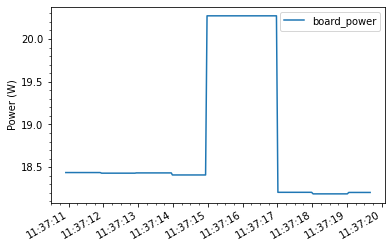

In [13]:
powers = pd.DataFrame(index=f.index)
powers['board_power'] = f['12v_aux_power'] + f['12v_pex_power']
ax = powers.plot()
plt.minorticks_on()
ax.set_ylabel("Power (W)")

# PyTorch実行

In [14]:
class CNN(torch.nn.Module):
    def __init__(self, num_output_classes=10):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 2 * 2, 256)
        self.fc2 = nn.Linear(256, 10)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        x = self.relu(self.conv4(x))
        x = self.pool(x)
        x = x.view(-1, 64 * 2 * 2)
        x = self.relu(self.fc1(x))      
        x = self.fc2(x)
 
        return x

In [15]:
net = CNN()

In [16]:
# 保存しているtorchのパラメタを持ってくる
load_weights = torch.load('model72.pt')
net.load_state_dict(load_weights)

<All keys matched successfully>

In [17]:
outputs = net(images)

/home/yamada/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448216815/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


### 目視での確認

In [18]:
print(y[200:210])

[-14.902344   -17.798828   -14.714844   -11.888672    -8.552734
  -8.919922   -19.884766    -0.84765625 -20.535156   -13.5859375 ]


In [19]:
print(outputs.detach().numpy().flatten()[200:210])

[-14.436577   -17.064035   -14.196071   -11.521516    -8.409033
  -8.547713   -19.108736    -0.81221604 -19.931944   -13.066869  ]


# 評価

In [20]:
#ラベル
ll = []
for i in range(N):
    ll.append(classes2[labels[i]])

# pytorch結果
cpu = torch.argmax(outputs, dim=1)
cpu = np.array(cpu)

# fpga結果の表示
fpga = []
for i in range(N):
    fpga.append(np.argmax(y[i*10:i*10+10]))

In [21]:
# PytorchとFPGAの差
count = 0
for c in range(N):
    if(cpu[c] == fpga[c]):
        count += 1
count = count/N * 100
print(count)

98.72


In [22]:
# FPGAの精度
count = 0
for c in range(N):
    if(int(ll[c]) == fpga[c]):
        count += 1
count = count/N * 100
print(f'精度：{count}％')

精度：79.72％


In [23]:
%xdel y
%xdel x
ol.free()